In [34]:
library(rvest)
library(stringr)
library(tidyverse)
library(ggplot2)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

We are going to use two datasets cooperatively in this project. Below is the information about each dataset.
### Dataset 1: "sessions.csv"
* Number of observations: 1535
* Number of variables: 5
* Names and types of variables:
* * 3 variables of type chr (string): hashedEmail, start_time, end_time
* * 2 variables of type dbl (numeric): original_start_time, original_end_time
* Meaning of each variable:
* * hashedEmail: A hashed format of the email address
* * start_time: The start time of each session when the player begins playing the game
* * end_time: The end time of each session when the player finishes playing the game
* * original_start_time: The start time represented as a timestamp in scientific notation (milliseconds since January 1, 1970) for each session that the player start to play the game. 
* * original_end_time: The end time represented as a timestamp in scientific notation (milliseconds since January 1, 1970) for each session that the player start to play the game. 

The data is collected as event logs when users play the game.

#### Potential issues:
* start_time and end_time are in string format. To calculate the time the users spend, we need to convert these columns into a numerical format that allows for mathematical calculations (end_time - start_time).
* original_start_time and original_end_time are stored in scientific notation. These timestamps may need to be converted into a human-readable time format before calculating the difference to determine the time a player spent. For example, May 26, 2023, 01:49:30 UTC and June 18, 2023, 16:00:00 UTC if these 2 are the variables of interest.

### Dataset 2: "players.csv"
* Number of observations: 196
* Number of variables: 9
* Names and types of variables:
* * 4 variables of type chr (string):hashedEmail, experience, name, gender
* * 2 variables of type dbl (numeric):played_hours, age
* * 3 variables of type lgl (Boolean):subscribe, individualId, organizationName
* Meaning of each variable:
* * hashedEmail: A hashed format of the email address
* * experience: Categorizes the player’s experience level into five groups: Pro, Veteran, Amateur, Regular, and Beginner
* * name: The player’s name
* * gender: The player’s gender
* * played_hours: The total number of hours the player has spent playing the game
* * age: The player’s age
* * subscribe: Whether the player subscribes to the game or not
* * individualId: The ID for each individual
* * organizationName: The name of the organization associated with the observation
#### Potential issues:
* The individualId and organizationName columns are empty, contain missing values.
* How is the experience level categorized? Is there a standard for this, or is it self-reported by the player? More associated clarification needed. 

#### Question:

What player characteristics (such as age, experience level, and average time per play session) are most strongly associated with higher total playtime in Minecraft? In this project, we will develop a predictive model using these 3 factors to predict total playtime, with the goal of identifying key traits that contribute to player engagement and data generation.

#### Plan to wrangle the data:

We would like to use the KNN regression method to predict the total play hours spent on the game based on players' experience level, age, and average time per play session. First, in "sessions.csv", convert the start_time and end_time columns into a numerical format, then create a new column called time_each_session by calculating end_time - start_time. Next, group the data by hashedEmail and summarize it, showing the average time per play session for each player. After that, merge the two dataframes based on hashedEmail. Finally, split the combined dataset into trainig set and testing set. Perform data training to find the best K on training set and then do prediction on testing set, find RMSPE value to determine if this is a good model. 

In [27]:
# players
players<-read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
# sessions
sessions<-read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
#wrangle data, per session time in minutes
sessions$start_time <- as.POSIXct(sessions$start_time, format = "%d/%m/%Y %H:%M")
sessions$end_time <- as.POSIXct(sessions$end_time, format = "%d/%m/%Y %H:%M")
sessions <- sessions %>%
  mutate(time_per_session_in_min = as.numeric(difftime(end_time, start_time, units = "mins")))

In [29]:
#group and summarized average play time per session in hours based on hashedmail.
new_sessions<-sessions|>
group_by(hashedEmail)|>
summarize(avg_play_t_in_h=mean(time_per_session_in_min/60))
# new_sessions

In [30]:
#combine the 2 dataframe
combined_df<-left_join(players,new_sessions)
#mutate the experience column into a new column called exp_lvl_num for easier analysis
combined_df<-combined_df|>
mutate(exp_lvl_num=case_when(experience=="Beginner"~1,
                             experience=="Amateur"~2,
                             experience=="Regular"~3,
                             experience=="Veteran"~4,
                             experience=="Pro"~5))

Joining with `by = join_by(hashedEmail)`


In [31]:
#split the combined_df and get the training and testing data
combined_df_split<-initial_split(combined_df, prop=0.75, strata=played_hours)
combined_df_training<-training(combined_df_split)
combined_df_testing<-testing(combined_df_split)

Warning message:
“Removed 55 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 55 rows containing missing values or values outside the scale range
(`geom_point()`).”


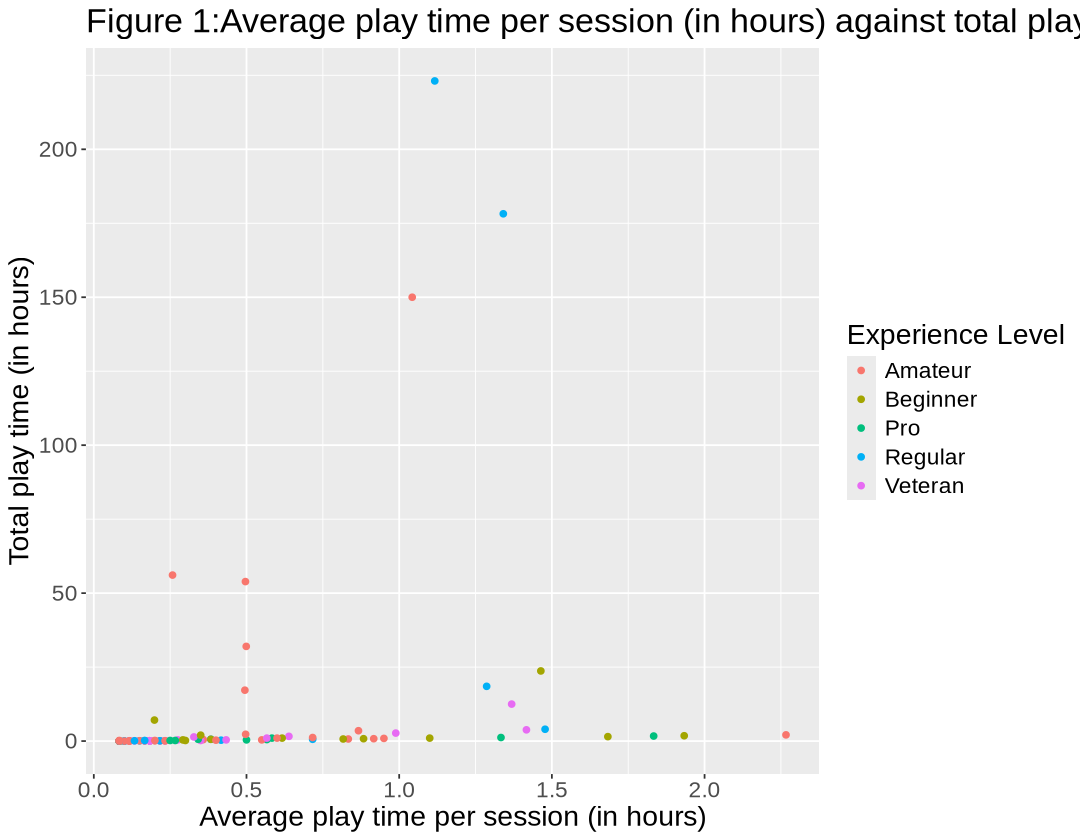

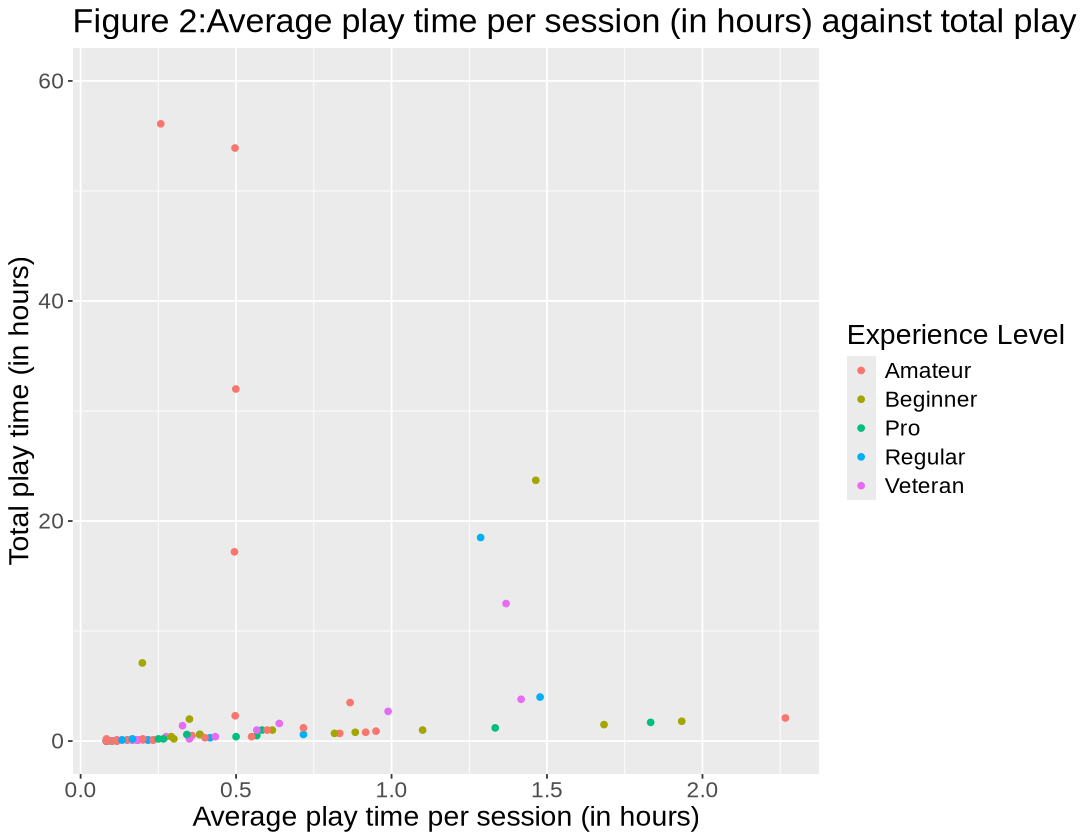

In [32]:
#see the plot of average play time per session (in hours) against total play hours
options(repr.plot.width = 9, repr.plot.height = 7) 
plot<-ggplot(combined_df_training,aes(x=avg_play_t_in_h,y=played_hours, color=experience))+
geom_point()+
ggtitle("Average play time per session against total play hours")+
labs(x="Average play time per session (in hours)", y="Total play time (in hours)", color="Experience Level")+
theme(text=element_text(size=17))+ 
ggtitle("Figure 1:Average play time per session (in hours) against total play hours")

plot

#zoom in plot to see majority
plot+coord_cartesian(ylim = c(0, 60))+
ggtitle("Figure 2:Average play time per session (in hours) against total play hours(zoom in)")

#### Insights

From the plots above we can see there is no linear relationship between average play time per session (in hours) and total play hours. Linear regression may not be a good model. 

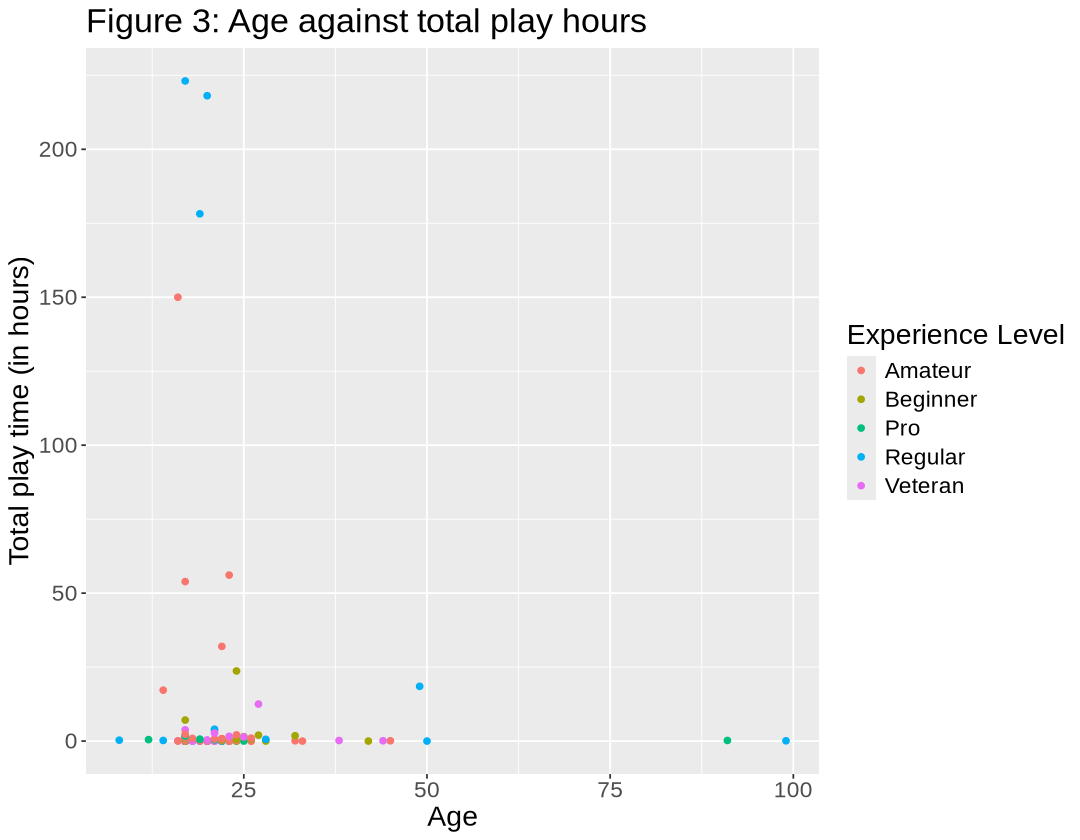

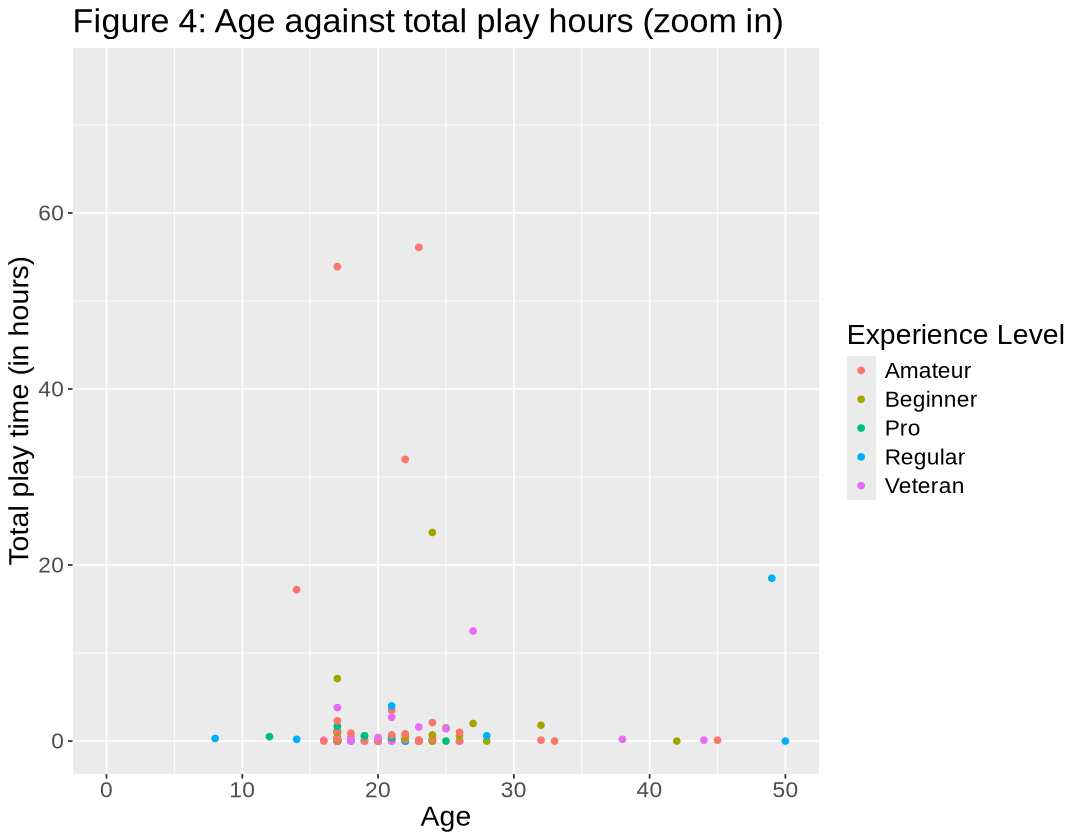

In [33]:
#see the plot of age against total play hours
options(repr.plot.width = 9, repr.plot.height = 7) 
plot2<-ggplot(combined_df_training,aes(x=age,y=played_hours, color=experience))+
geom_point()+
ggtitle("Age against total play hours")+
labs(x="Age", y="Total play time (in hours)", color="Experience Level")+
theme(text=element_text(size=17))+
ggtitle("Figure 3: Age against total play hours")

plot2
#most of our player are aged equal or below 50. 

#zoom in plot to see majority
plot2+coord_cartesian(xlim = c(0, 50),ylim = c(0, 75))+
ggtitle("Figure 4: Age against total play hours (zoom in)")

#### Insights

From the plots above we can see there is no linear relationship between age and total play hours. Linear regression may not be a good model. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 65 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


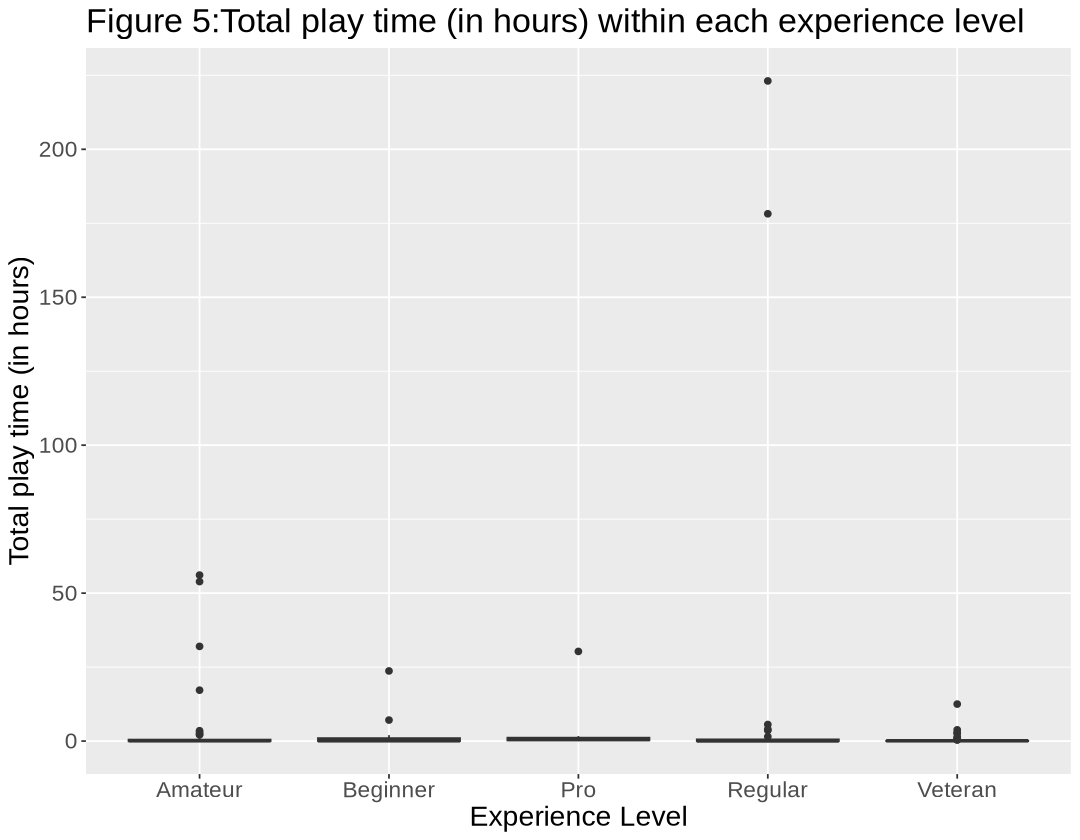

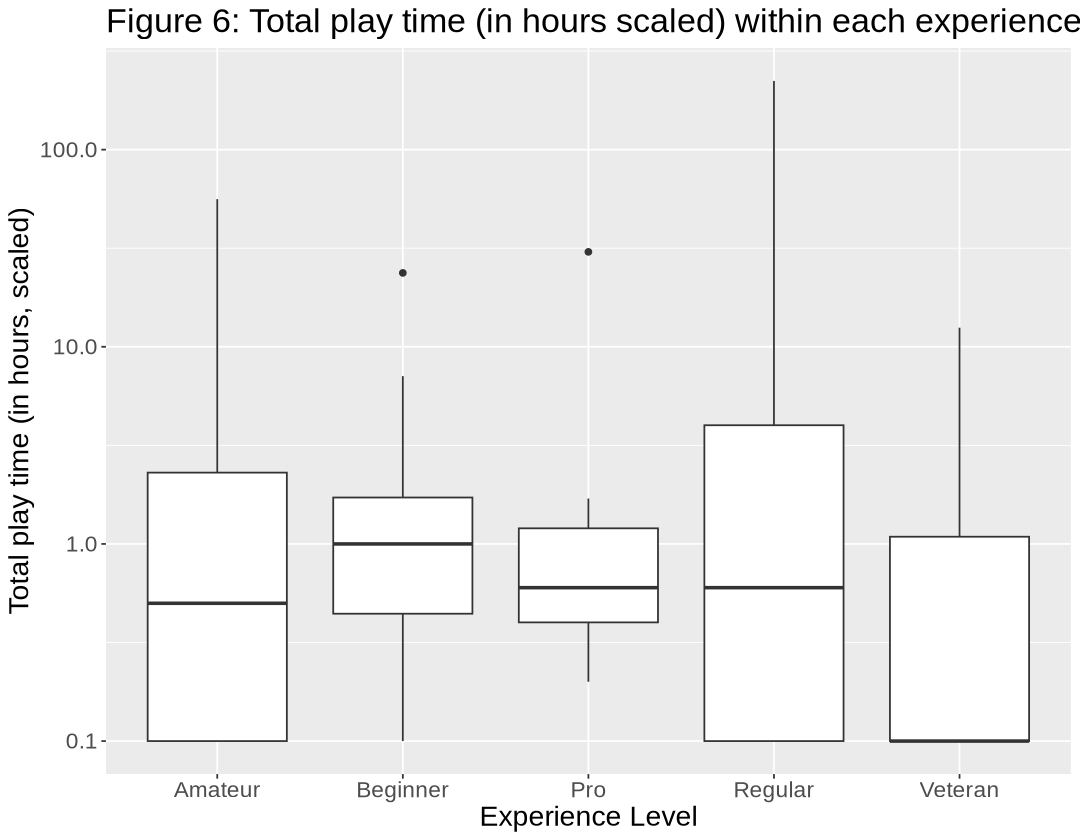

In [25]:
#creating a box plot to see the total played hours for each experience level
options(repr.plot.width = 9, repr.plot.height = 7) 
plot3<-combined_df_training|>ggplot(aes(x=experience, y=played_hours)) + geom_boxplot() +
labs(x="Experience Level", y="Total play time (in hours)")+
theme(text=element_text(size=17)) + ggtitle("Figure 5:Total play time (in hours) within each experience level")

plot3

#we need to scale the y-axis in order to get a more clear visualization of the boxplots
plot3<-plot3 + 
scale_y_log10()+
labs(y="Total play time (in hours, scaled)")+
ggtitle("Figure 6: Total play time (in hours scaled) within each experience level")
plot3

#### Insights

The boxplots illustrate the distribution of the total number of play hours between different kinds of experience levels. Looks like the distribution is not even, so experience level might be a good predicted variable.

#### Method and Plan
We are going to use the k-nearest neighbors (KNN) regression algorithm on the combined two datasets. This is because, first, our response variable is numerical (total paly hours on Minecraft), and second, we don’t want to make assumptions about the underlying data distribution. Additionally, we don't see a linear relationship between our target variable and the predictor variables based on the graph, so KNN regression is a good choice. The assumption behind KNN is that similar points tend to be near each other.

However, one limitation of KNN is its sensitivity to noise and outliers. If an outlier is close to the test point, KNN may incorrectly predict the target value.

After combining the two dataframes based on hashedEmail, we will split the new combined dataset into a training set (75%) and a testing set (25%). Find the best value of K on trainig dataset. During the process of finding the best K, we will also use 5-fold cross-validation and a series of K-vals.

In [ ]:
%>%
  set_engine("kknn") %>%
  set_mode("regression")


combined_cv <- vfold_cv(combined_df_training, v = 3, strata = played_hours)


knn_wf <- workflow() %>%
  add_model(knn_spec) %>%
  add_recipe(recipe_preprocess)


knn_grid <- grid_regular(neighbors(), levels = 10)

knn_res <- tune_grid(
  object = knn_wf,
  resamples = combined_cv,
  grid = knn_grid,
  metrics = metric_set(rmse)
)


show_notes(knn_res)


best_k <- select_best(knn_res, metric = "rmse")


final_knn <- finalize_workflow(knn_wf, best_k)


final_knn_fit <- fit(final_knn, data = combined_df_training)


knn_predictions <- predict(final_knn_fit, new_data = combined_df_testing)


knn_results <- metrics(
  data = bind_cols(knn_predictions, combined_df_testing),
  truth = played_hours,
  estimate = .pred
)


print(knn_results)